# Tutorial 16: Randomized DMD

In this tutorial, we re-examine the system explored in [Tutorial 4](https://pydmd.github.io/PyDMD/tutorial4cdmd.html) and compare the performance of compressed DMD (CDMD) and randomized DMD (RDMD) [1] as a means of improving the efficiency of the exact DMD algorithm. We highlight RDMD as an effective alternative to its predecessor CDMD, while also highlighting how one might tune the parameters of RDMD in order to balance accuracy and efficiency.

[1] N. B. Erichson, L. Mathelin, J. N. Kutz, and S. L. Brunton, *Randomized dynamic mode decomposition*, SIAM J. Appl. Dyn. Syst., 18 (2019), pp. 1867-1891. https://doi.org/10.1137/18M1215013

We begin by importing the `RDMD` class from the PyDMD package, along with the `DMD` and `CDMD` classes for performance comparisons. We also import the `time` module for calculating runtime, `numpy` for mathematical computations, and `matplotlib.pyplot` for plotting.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD, CDMD, RDMD

We then define a function for calculating relative error, along with a function for computing the CDMD compression matrix used in Tutorial 4.

In [2]:
def compute_error(true, est):
    """
    Computes and returns relative error.
    """
    return np.linalg.norm(true - est) / np.linalg.norm(true)

def build_compression_matrix(snapshots_matrix):
    """
    Computes and returns the CDMD compression matrix used in Tutorial 4.
    """
    random_matrix = np.random.permutation(
        snapshots_matrix.shape[0] * snapshots_matrix.shape[1]
    )
    random_matrix = random_matrix.reshape(
        snapshots_matrix.shape[1], snapshots_matrix.shape[0]
    )
    compression_matrix = random_matrix / np.linalg.norm(random_matrix)

    return compression_matrix

## The Toy Data Set

Now, we re-create the helper function from Tutorial 4 that returns toy data snapshots for a given spatial and temporal resolution. Each data snapshot is the sum of the following three components, with $x \in [-5, 5]$ and $t \in [0, 4\pi]$.

- $f_1(x, t) = e^{\frac{-x^2}{5}}\,\cos(4x)\,e^{(2.3i)t}$
- $f_2(x, t) = \bigg(1-e^{1-\frac{x^2}{6}}\bigg)e^{(1.3i)t}$
- $f_3(x, t) = \bigg(-\frac{x^2}{50} + 1\bigg)1.1i^{-2t}$

Here we produce our toy data set for 256 spatial collocation points across 128 time points. We then add Gaussian noise to our data so that we may compare method performance in the presence of measurement noise. The clean data and the noisy data sets are then plotted.

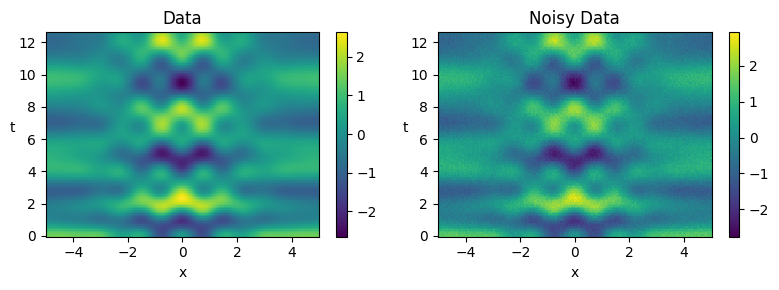

In [3]:
def create_dataset(x_dim, t_dim):
    """
    Args:
        x_dim = resolution along the x range [-5, 5]
        t_dim = resolution along the t range [0, 4*pi]

    Returns:
        x_grid = x collocation points
        t_grid = t collocation points
        X = (t_dim, x_dim) np.ndarray of snapshot data
    """
    # Define the x and t collocation points.
    x = np.linspace(-5, 5, x_dim)
    t = np.linspace(0, 4 * np.pi, t_dim)
    xgrid, tgrid = np.meshgrid(x, t)

    # Define the modes that make up each snapshot.
    def f1(x, t):
        return np.exp(-(x**2) / 5) * np.cos(4 * x) * np.exp(2.3j * t)

    def f2(x, t):
        return (1 - np.exp(1 - (x**2) / 6)) * np.exp(1.3j * t)

    def f3(x, t):
        return (-((x**2) / 50) + 1) * (1.1j ** (-2 * t))

    # Evaluate modes at each collocation point.
    X1 = f1(xgrid, tgrid)
    X2 = f2(xgrid, tgrid)
    X3 = f3(xgrid, tgrid)

    return xgrid, tgrid, (X1 + X2 + X3)

# Generate and visualize the toy dataset.
xgrid, tgrid, X = create_dataset(x_dim=256, t_dim=128)

# Generate noisy data for a given noise magnitude. Seed is used for reproducibility.
noise_mag = 0.1
rng = np.random.default_rng(seed=42)
X_noisy = X + (noise_mag * rng.standard_normal(X.shape))

# Plot both the clean and the noisy data sets. 
plt.figure(figsize=(8, 3))
for i, (mat, name) in enumerate(zip([X, X_noisy], ["Data", "Noisy Data"])):
    plt.subplot(1, 2, i + 1)
    plt.pcolor(xgrid, tgrid, mat.real)
    plt.colorbar()
    plt.title(name)
    plt.xlabel("x")
    plt.ylabel("t", rotation=0)
plt.tight_layout()
plt.show()

## Exact DMD

We begin by applying exact DMD to our data so that its results may serve as a benchmark for CDMD and RDMD. Note that throughout this tutorial, we will fit our models to the noisy data set and use our models' ability to reconstruct the clean signal as a proxy for model accuracy. Furthermore, we record fitting time for all methods in order to compare method efficiency. Here, we replicate the DMD approach used in Tutorial 4.

In [13]:
# Define the data matrices to be used for model fitting.
snapshots_matrix = X.T
snapshots_matrix_noisy = X_noisy.T

# Fit a DMD model.
t0 = time.time()
dmd = DMD(svd_rank=3, exact=True)
dmd.fit(snapshots_matrix_noisy)
t1 = time.time()

# Record and print model error and training time.
dmd_error = compute_error(snapshots_matrix, dmd.reconstructed_data)
dmd_time = t1 - t0
print(f"DMD Reconstruction Error: {dmd_error}")
print(f"DMD Training Time: {dmd_time}")

DMD Reconstruction Error: 0.017055067185643223
DMD Training Time: 0.1719956398010254


## Compressed DMD

Now we apply CDMD to our data, where we again compute error and training time when given noisy data. Here, we compute these metrics across multiple trials in order to account for variations that result from randomness. We additionally utilize the compression matrix used in Tutorial 4 for all CDMD models as to replicate the Tutorial 4 approach. We also begin by including the time needed to compute the compression matrix in our CDMD training time.

In [12]:
# Define the number of random trials to perform.
num_trials = 100

# Initialize the error and runtime metrics.
cdmd_error = 0.0
cdmd_time = 0.0

for _ in range(num_trials): # Perform multiple trials...
    # Fit a CDMD model.
    t0 = time.time()
    compression_matrix = build_compression_matrix(snapshots_matrix)
    cdmd = CDMD(svd_rank=3, compression_matrix=compression_matrix)
    cdmd.fit(snapshots_matrix_noisy)
    t1 = time.time()
    # Incorporate this trial's results into the running averages.
    cdmd_error += compute_error(snapshots_matrix, cdmd.reconstructed_data) / num_trials
    cdmd_time += (t1 - t0) / num_trials

# Print average model error and training runtime.
print(f"CDMD Reconstruction Error: {cdmd_error}")
print(f"CDMD (Average) Training Runtime: {cdmd_time}")

CDMD Reconstruction Error: 0.02878487116412562
CDMD (Average) Training Runtime: 0.08478243350982666


## Randomized DMD: Varying Oversampling

We now examine the performance of RDMD, which is derived in [1] and implemented in the `RDMD` class of PyDMD.

The performance of the RDMD algorithm is manually toggled by 2 major parameters, one of which is the *oversampling* parameter, which controls the number of additional random samples (beyond the predicted rank of the data) that are used to compute a basis for the range of the input data. In short, increasing the oversampling increases the probability that one is able to construct a good RDMD basis, yet it simultaneously increases runtime due to the usage of a larger random test matrix. It should be noted that in general, a small oversampling value approximately within the range of $[5, 10]$ often suffices [1].

Here, we demonstate how the performance of the `RDMD` module is impacted by the `oversampling` parameter, which is `10` by default and can be toggled upon the initialization of an `RDMD` model. Here, we examine oversampling values within the range $[0, 20]$ and we again fit our RDMD models to noisy data across multiple random trials. We then compare the average error and training time to that of exact DMD and CDMD.

In [16]:
# Define the default PyDMD oversampling value.
oversampling_default = 10

# Define the oversampling values to investigate.
oversampling_values = np.arange(0, 51, 5)

# Initialize the error and runtime metrics.
oversampling_error = np.zeros(len(oversampling_values))
oversampling_times = np.zeros(len(oversampling_values))

for i, oversampling in enumerate(oversampling_values):
    for _ in range(num_trials): # Perform multiple trials...
        # Fit an RDMD model.
        t0 = time.time()
        rdmd = RDMD(svd_rank=3, oversampling=oversampling).fit(snapshots_matrix_noisy)
        t1 = time.time()
        # Incorporate this trial's results into the running averages.
        oversampling_error[i] += compute_error(snapshots_matrix, rdmd.reconstructed_data) / num_trials
        oversampling_times[i] += (t1 - t0) / num_trials

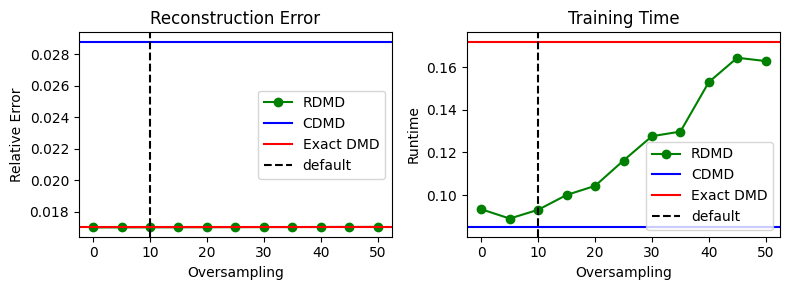

In [20]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(oversampling_values, oversampling_error, "-o", c="g", label="RDMD")
plt.axhline(y=cdmd_error, c="b", label="CDMD")
plt.axhline(y=dmd_error, c="r", label="Exact DMD")
plt.axvline(x=oversampling_default, ls="--", c="k", label="default")
plt.title("Reconstruction Error")
plt.xlabel("Oversampling")
plt.ylabel("Relative Error")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(oversampling_values, oversampling_times, "-o", c="g", label="RDMD")
plt.axhline(y=cdmd_time, c="b", label="CDMD")
plt.axhline(y=dmd_time, c="r", label="Exact DMD")
plt.axvline(x=oversampling_default, ls="--", c="k", label="default")
plt.title("Training Time")
plt.xlabel("Oversampling")
plt.ylabel("Runtime")
plt.legend()
plt.tight_layout()
plt.show()

## Randomized DMD: Varying Power Iterations

Another major RDMD parameter is the number of *power iterations* used during the randomized QB decomposition process. The use of power iterations is a data preprocessing step that promotes faster singular value decay and hence leads to better basis approximations. Hence similar to the oversampling parameter, increasing the number of power iterations leads to increased accuracy with the drawback of increased runtime due to the need to pass through the data at each power iteration. In general, as little as $1$ or $2$ power iterations often suffice [1].

The number of power iterations used may also be toggled upon the initialization of an `RDMD` model via the `power_iters` argument, which is `2` by default.

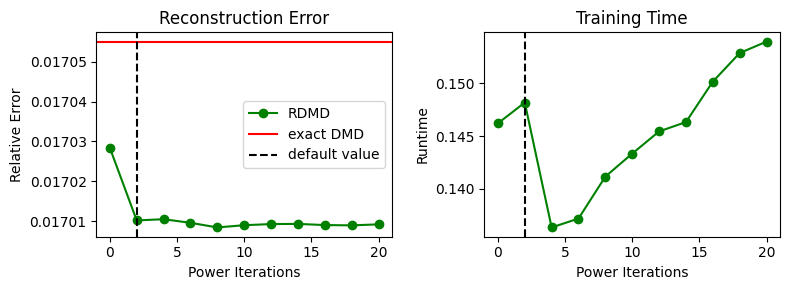

In [62]:
power_iter_default = 2
power_iter_values = np.arange(0, 21, 2)
power_iter_error = np.zeros(len(power_iter_values))
power_iter_times = np.zeros(len(power_iter_values))

for i, power_iters in enumerate(power_iter_values):
    for _ in range(num_trials):
        t0 = time.time()
        rdmd = RDMD(svd_rank=3, power_iters=power_iters).fit(snapshots_matrix_noisy)
        t1 = time.time()
        power_iter_error[i] += compute_error(snapshots_matrix, rdmd.reconstructed_data) / num_trials
        power_iter_times[i] += (t1 - t0) / num_trials

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(power_iter_values, power_iter_error, "-o", c="g", label="RDMD")
# plt.axhline(y=cdmd_error, c="b", label="CDMD")
plt.axhline(y=dmd_error, c="r", label="exact DMD")
plt.axvline(x=power_iter_default, ls="--", c="k", label="default value")
plt.title("Reconstruction Error")
plt.xlabel("Power Iterations")
plt.ylabel("Relative Error")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(power_iter_values, power_iter_times, "-o", c="g", label="RDMD")
plt.axhline(y=cdmd_time, c="b", label="CDMD")
plt.axhline(y=dmd_time, c="r", label="exact DMD")
plt.axvline(x=power_iter_default, ls="--", c="k", label="default value")
plt.title("Training Time")
plt.xlabel("Power Iterations")
plt.ylabel("Runtime")
plt.tight_layout()
plt.show()

## Runtime Comparison

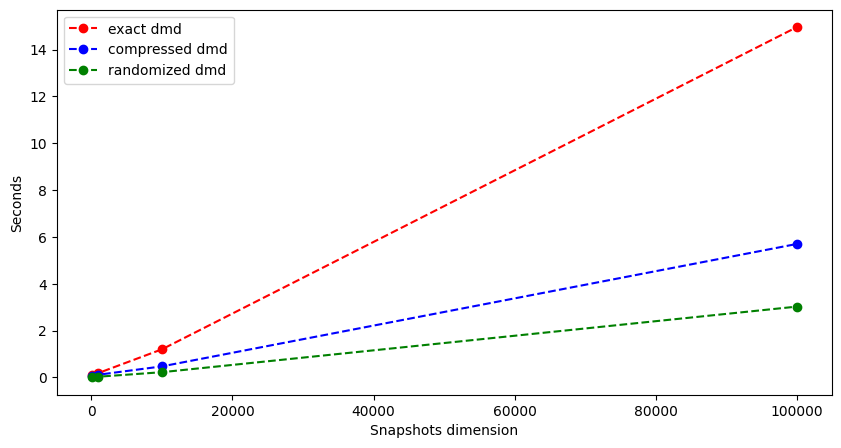

In [22]:
time_dmd = []
time_cdmd = []
time_rdmd = []

niter = 4
nsnap = 100
ndims = 10 ** np.arange(2, 2 + niter)
for ndim in ndims:
    snapshots_matrix = create_dataset(ndim, nsnap)[-1].T

    # Build compression matrix for CDMD.
    compression_matrix = build_compression_matrix(snapshots_matrix)
    
    # Build random matrix for RDMD.
    rand_mat = np.random.randn(snapshots_matrix.shape[-1], 5)

    t0 = time.time()
    DMD(svd_rank=-1, exact=True).fit(snapshots_matrix)
    t1 = time.time()
    time_dmd.append(t1 - t0)

    t0 = time.time()
    CDMD(svd_rank=-1, compression_matrix=compression_matrix).fit(snapshots_matrix)
    t1 = time.time()
    time_cdmd.append(t1 - t0)
    
    t0 = time.time()
    RDMD(svd_rank=-1, rand_mat=rand_mat).fit(snapshots_matrix)
    t1 = time.time()
    time_rdmd.append(t1 - t0)

plt.figure(figsize=(10, 5))
plt.plot(ndims, time_dmd, "ro--", label="exact dmd")
plt.plot(ndims, time_cdmd, "bo--", label="compressed dmd")
plt.plot(ndims, time_rdmd, "go--", label="randomized dmd")
plt.legend()
plt.ylabel("Seconds")
plt.xlabel("Snapshots dimension")
plt.show()

## In summary...
- In general, `RDMD` tends to be faster and more accurate than `CDMD`.
- By default, `oversampling = 10` and `power_iters = 2`, as these are generally effective parameter choices.
- Increasing either `oversampling` or `power_iters` often increases accuracy at the expense of greater runtimes.